# Task 2

In [13]:
import matplotlib.pyplot as plt
import pandas as pd
import re
import json
import random
from pathlib import Path
from PIL import Image
import numpy as np
from collections import OrderedDict
import torch
from torch import nn, optim
import os
import re
import json
import pandas as pd
from concurrent.futures import ProcessPoolExecutor
from tqdm.auto import tqdm
import cv2
import sys
sys.path.append('./ACDS')
sys.path.append('./ACDS/Image')
sys.path.append('./ACDS/Speed')

from ACDS.Speed import *
# from ACDS.Speed import helper

In [2]:
import random
import matplotlib.pyplot as plt
# import seaborn as sns
from pathlib import Path
from PIL import Image
from torchvision import datasets, transforms
plt.style.use('default')

def visualize_images(image_path, cols=10, rows=10, seed=42, transform=None):
    random.seed(seed) # <- try changing this and see what happens
    image_path = Path(image_path)
    image_path_list = list(image_path.glob("*/*.jpg"))
    figure = plt.figure(figsize=(6, 6))

    for i in range(cols * rows):
        random_image_path = random.choice(image_path_list)
        img = Image.open(random_image_path)

        figure.add_subplot(rows, cols, i+1)
        plt.axis("off")
        plt.imshow(img, cmap="gray")

    return image_path_list

def plot_transformed_images(image_path, t):
    # open grey scale image
    with Image.open(image_path).convert('L') as f:
        fig, ax = plt.subplots(1, 2)
        ax[0].imshow(f, cmap="gray")
        ax[0].set_title(f"Original \nSize: {f.size}")
        ax[0].axis("off")

        transformed_image = t(f)
        transformed_image = np.array(transformed_image)[0]
        ax[1].imshow(transformed_image, cmap="gray")
        ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
        ax[1].axis("off")

def transformer(image_size=366, repair=False):
    if repair:
            transform = transforms.Compose([
            transforms.Grayscale(),
            transforms.Resize((image_size, image_size)),
            RepairImageTransform(),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485], std=[0.229]),
            # transforms.Grayscale(),
        ])
    else:
            transform = transforms.Compose([
            transforms.Grayscale(),
            transforms.Resize((image_size, image_size)),
            # RepairImageTransform(),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485], std=[0.229]),
            # transforms.Grayscale(),
        ])
            
    return transform

class RepairImageTransform:
    def __init__(self, threshold=240, radius=9, kernel_size=3):
        self.threshold = threshold
        self.radius = radius
        self.kernel_size = kernel_size

    def __call__(self, image):
        # Convert PIL image to numpy array for processing
        image_array = np.array(image)

        # Apply threshold to create a mask for inpainting
        _, mask = cv2.threshold(image_array, self.threshold, 255, cv2.THRESH_BINARY)

        # Use inpainting to repair the image
        repaired_image = cv2.inpaint(image_array, mask, self.radius, cv2.INPAINT_TELEA)

        # Apply median blur to reduce noise
        denoised_image = cv2.medianBlur(repaired_image, self.kernel_size)

        # Convert the processed numpy array back to a PIL Image
        # Ensure it stays as a grayscale image
        result_image = Image.fromarray(denoised_image)

        return result_image

## 1. Data prepreocessing 


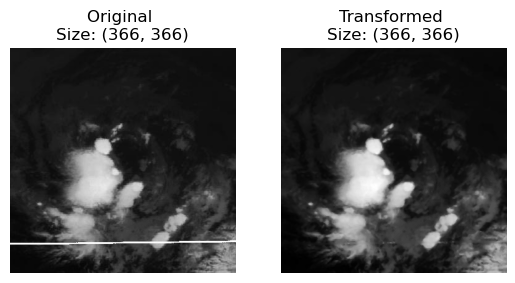

In [10]:
path = '../../data/Selected_Storms_curated_to_zip/blq/blq_105.jpg'
plot_transformed_images(path, transformer(image_size=366, repair=True))

## 2. Dataset and dataloader


In [14]:
import matplotlib.pyplot as plt
import json
import random
from pathlib import Path
from PIL import Image
import numpy as np
from collections import OrderedDict
from torch import nn, optim
import re
import pandas as pd
from concurrent.futures import ProcessPoolExecutor
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import os
from tqdm.auto import tqdm

class StormDataset(Dataset):
    def __init__(self, root_dir, raw_data_dir, storm_name, transform=None, split_ratio = 0.9, sequence_length=5,
                 additional_features= None, 
                 label_type='wind_speed',
                 type='train'
                 ):
        """
        root_dir: 存放所有风暴数据的文件夹路径
        transform: 对图像进行预处理的转换
        """
        self.root_dir = root_dir
        self.raw_data_dir = raw_data_dir
        self.storm_name = storm_name
        self.transform = transform
        if transform is None:
            self.transform = transforms.Compose([
                transforms.Grayscale(),
                transforms.ToTensor(),
            ])
        self.type = type
        self.split_ratio = split_ratio
        self.sequence_length = sequence_length
        self.additional_features = additional_features
        if additional_features is not None:
            self.num_features = len(additional_features)
        else:
            self.num_features = 0
        self.label_type = label_type
        self.samples, self.images_samples = self._get_samples()
        self.sample = None
        self.image_sample = None
    
    def _get_samples(self):

        raw_data = pd.read_csv(self.raw_data_dir)
        raw_data_sorted = raw_data.sort_values(by=['Storm_Name', 'Relative_time'])
        samples = raw_data_sorted[raw_data_sorted['Storm_Name'] == self.storm_name].copy()
        split_index = int(len(samples) * self.split_ratio)
        if self.type == 'train':
            samples = samples[:split_index]
        else:
            samples = samples[split_index:]
            
        images_list = samples['Image_Path'].tolist()
        # read image data
        images_samples = []
        
        for image_path in images_list:
            image = Image.open(image_path)
            if self.transform:
                image = self.transform(image)
            images_samples.append(image)
        return samples, images_samples

    def __getitem__(self, idx):
        
        images, additional_features_sequence = [], []
        label = None
        
        # 起始点为idx, 结束点为idx + sequence_length
        for i in range(idx, idx + self.sequence_length):
            
            self.sample = self.samples.iloc[i].tolist()
            self.image_sample = self.images_samples[i]
            
            images.append(self.image_sample)
            
            if self.additional_features is not None:
                additional_features_sequence.append(self.get_additional_features())

        # 将列表转换为张量
        images = torch.stack(images)
        
        if self.additional_features is not None:
            additional_features_sequence = torch.stack(additional_features_sequence)

        # get label
        if self.label_type == 'wind_speed': 
            label = torch.tensor(float(self.sample[2]), dtype=torch.float)
        elif self.label_type == 'image':
            label = self.image_sample.unsqueeze(0)
            
        # print(label)
        if self.additional_features is not None:
            return images[:-1], additional_features_sequence[:-1], label
        else:
            return images[:-1], label
        
    def __len__(self):
        # 因为我们需要连续的序列，所以总长度需要减去序列长度
        return len(self.samples) - self.sequence_length + 1
    
    def get_additional_features(self):
        storm_name, id, wind_speed, relative_time, ocean, image_path  = self.sample
        additional_features_list = []
        
        for feature in self.additional_features:
            if feature == 'wind_speed':
                additional_features_list.append(torch.tensor(float(wind_speed), dtype=torch.float))
                wind_speed = torch.tensor(float(wind_speed), dtype=torch.float)
            elif feature == 'relative_time':
                additional_features_list.append(torch.tensor(float(relative_time), dtype=torch.float))
                relative_time = torch.tensor(float(relative_time), dtype=torch.float)
            elif feature == 'ocean':
                additional_features_list.append(torch.tensor(float(ocean), dtype=torch.float))
            elif feature == 'id':
                additional_features_list.append(torch.tensor(float(id), dtype=torch.float))
                
        return torch.stack(additional_features_list)
    
def train_test_split(root_dir, raw_data_dir, storm_name, transform, split_ratio, sequence_length,
                    additional_features, 
                    label_type
                     ):
    train_dataset = StormDataset(root_dir=root_dir, 
                             raw_data_dir=raw_data_dir, 
                             storm_name=storm_name, 
                             transform=transform, 
                             split_ratio=split_ratio, 
                             sequence_length=sequence_length,
                             additional_features=additional_features,
                             label_type=label_type,
                             type='train'
                             )
    test_dataset = StormDataset(root_dir=root_dir, 
                            raw_data_dir=raw_data_dir, 
                            storm_name=storm_name, 
                            transform=transform, 
                            split_ratio=split_ratio, 
                            sequence_length=sequence_length,
                            additional_features=additional_features,
                            label_type=label_type,
                            type='test'
                            )
    return train_dataset, test_dataset

def make_datasets(root_dir, raw_data_dir, storm_names, transform=None, split_ratio=0.9, sequence_length=5,
                  additional_features=None,
                  label_type = 'wind_speed',
                  ):
    
    datasets = {storm_name: [] for storm_name in storm_names}
    for storm_name in tqdm(storm_names):
        train_dataset, test_dataset = train_test_split(root_dir, raw_data_dir, storm_name, transform, split_ratio, sequence_length, additional_features, label_type)
        datasets[storm_name].append(train_dataset)
        datasets[storm_name].append(test_dataset)
    return datasets

def make_dataloaders(datasets, storm_names, batch_size=1, shuffle=False):
    dataloaders = {storm_name: [] for storm_name in storm_names}
    for storm_name in tqdm(storm_names):
        train_loader = DataLoader(datasets[storm_name][0], batch_size=batch_size, shuffle=shuffle)
        test_loader = DataLoader(datasets[storm_name][1], batch_size=batch_size, shuffle=shuffle)
        dataloaders[storm_name].append(train_loader)
        dataloaders[storm_name].append(test_loader)
    return dataloaders

##  3. Model design and implementation



### 3.1 SimpleCNN

Not include here

### 3.2 Randomforest

Not include here

### 3.3 CNNLSTM

#### 3.3.1 CNNLSTM (ResNet18)

In [5]:
from torchvision.models import resnet18, ResNet18_Weights
from torch import nn, optim
from torch.nn import functional as F
import torch

class CNNLSTM_V1(nn.Module):
    def __init__(self, cnn_output_size, hidden_size, num_layers, num_features=0, image_size=366):
        super().__init__()
        self.num_features = num_features
        self.cnn = resnet18(weights=ResNet18_Weights.DEFAULT)
        # Modify the first convolution layer to accept single-channel (gray) images
        self.cnn.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        # self.cnn.fc = nn.Linear(self.cnn.fc.in_features, cnn_output_size)
        
        self.cnn.fc = nn.Sequential(
            nn.Linear(self.cnn.fc.in_features, cnn_output_size*4),
            nn.ReLU(),
            nn.Linear(cnn_output_size*4, cnn_output_size*2),
            nn.ReLU(),
            nn.Linear(cnn_output_size*2, cnn_output_size)
        )
        
        self.lstm = nn.LSTM(input_size=cnn_output_size + num_features,
                            hidden_size=hidden_size,
                            num_layers=num_layers,
                            batch_first=True)
        
        self.linear = nn.Sequential(
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Linear(hidden_size // 2, hidden_size // 4),
            nn.ReLU(),
            nn.Linear(hidden_size // 4, 1)
        )
        
    def forward(self, image_sequence, additional_features_sequence=None):
        # CNN处理每个时间步长的图像
        batch_size, seq_len, C, H, W = image_sequence.size()
        c_in = image_sequence.view(batch_size * seq_len, C, H, W)
        c_out = self.cnn(c_in)

        cnn_features = c_out.view(batch_size, seq_len, -1)
        # 将CNN提取的特征和附加特征相结合
        if additional_features_sequence is not None:
            combined_features = torch.cat((cnn_features, additional_features_sequence), 2)
        else:
            combined_features = cnn_features
        # LSTM处理特征序列
        lstm_out, _ = self.lstm(combined_features)
        last_time_step = lstm_out[:, -1, :]
        # 预测结果
        return self.linear(last_time_step).squeeze(0)
    ### 
    def predict(self, image_sequence, additional_features_sequence=None):
        with torch.no_grad():
            return self.forward(image_sequence, additional_features_sequence)


#### 3.3.2 CNNLSTM (SimpleCNN)

In [198]:
from torch import nn

class SimpleCNN(nn.Module):
    def __init__(self, input_channels=1, num_classes=10, feature_sizes=[64, 128], kernel_size=3, stride=1, padding=1):
        super(SimpleCNN, self).__init__()
        layers = []
        in_channels = input_channels
        # 动态创建卷积层
        for feature_size in feature_sizes:
            layers += [
                nn.Conv2d(in_channels, feature_size, kernel_size=kernel_size, stride=stride, padding=padding),
                nn.BatchNorm2d(feature_size),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=2, stride=2)
            ]
            in_channels = feature_size
        self.features = nn.Sequential(*layers)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(feature_sizes[-1], num_classes)
        
    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

# 修改CNNAugmentedLSTM类以使用SimpleCNN
class CNNLSTM_V2(nn.Module):
    def __init__(self, cnn_output_size, hidden_size, num_layers, num_features=0, input_channels=1, feature_sizes=[64, 128]):
        super().__init__()
        self.num_features = num_features
        # 使用SimpleCNN代替resnet18
        self.cnn = SimpleCNN(input_channels=input_channels, num_classes=cnn_output_size, feature_sizes=feature_sizes)
        
        self.lstm = nn.LSTM(input_size=cnn_output_size + num_features,
                            hidden_size=hidden_size,
                            num_layers=num_layers,
                            batch_first=True)
        
        self.linear = nn.Sequential(
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Linear(hidden_size // 2, hidden_size // 4),
            nn.ReLU(),
            nn.Linear(hidden_size // 4, 1)
        )
        
    def forward(self, image_sequence, additional_features_sequence=None):
        batch_size, seq_len, C, H, W = image_sequence.size()
        c_in = image_sequence.view(batch_size * seq_len, C, H, W)
        c_out = self.cnn(c_in)

        cnn_features = c_out.view(batch_size, seq_len, -1)
        if additional_features_sequence is not None:
            combined_features = torch.cat((cnn_features, additional_features_sequence), 2)
        else:
            combined_features = cnn_features
        lstm_out, _ = self.lstm(combined_features)
        last_time_step = lstm_out[:, -1, :]
        return self.linear(last_time_step).squeeze(0)

    def predict(self, image_sequence, additional_features_sequence=None):
        with torch.no_grad():
            return self.forward(image_sequence, additional_features_sequence)

#### 3.3.3 CNNLSTM (SimpleCNN)

Changed the input to lstm: only input additional feature sequence as input to lstm then merged with the features extracted from image sequence.

In [15]:
class SimpleCNN(nn.Module):
    def __init__(self, output_size, image_size):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=5, padding=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm2d(32)

        reduced_size = image_size // 4  
        self.fc = nn.Linear(32 * reduced_size * reduced_size, output_size)

    def forward(self, x):
        x = self.pool(self.relu(self.bn1(self.conv1(x))))
        x = self.pool(self.relu(self.bn2(self.conv2(x))))
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

class CNNLSTM_V3(nn.Module):
    def __init__(self, cnn_output_size, hidden_size, num_layers, num_features=0, image_size=224):
        super().__init__()
        self.num_features = num_features
        self.cnn = SimpleCNN(cnn_output_size, image_size)
        self.lstm_additional = nn.LSTM(input_size=self.num_features, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(cnn_output_size + hidden_size, (cnn_output_size + hidden_size)//2),
            nn.ReLU(),
            nn.Linear((cnn_output_size + hidden_size)//2, 1)
        )

    def forward(self, image_sequence, additional_features_sequence):
        batch_size, seq_len, C, H, W = image_sequence.size()
        c_in = image_sequence.view(batch_size * seq_len, C, H, W)
        c_out = self.cnn(c_in)
        cnn_features = c_out.view(batch_size, seq_len, -1)
        lstm_out, _ = self.lstm_additional(additional_features_sequence)
        last_time_step = lstm_out[:, -1, :]
        combined_features = torch.cat((cnn_features, last_time_step.unsqueeze(1).repeat(1, seq_len, 1)), 2)
        return self.fc(combined_features[:, -1, :]).squeeze(1)

    def predict(self, image_sequence, additional_features_sequence):
        return self.forward(image_sequence, additional_features_sequence)

## 4. Model training and evaluation

In [16]:
from livelossplot import PlotLosses

def save_model(model: torch.nn.Module,
               optimizer : torch.optim.Optimizer,
               checkpoint_dir: str,
               model_name: str,
               model_version: str,
               epoch=None,
               log=None,
               info=False):
  # Create target directory
  checkpoint_dir_path = Path(checkpoint_dir)
  checkpoint_dir_path.mkdir(parents=True, exist_ok=True)

  # Create model path
  if epoch is not None:
    model_name = f"{model_name}_{model_version}_{epoch}.pth"
  else:
    model_name = f"{model_name}_{model_version}.pth"

  model_save_path = checkpoint_dir_path / model_name
  checkpoint = {
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'epoch': epoch,
  }
  if log is not None:
      checkpoint['log'] = log
      
  torch.save(obj=checkpoint, f=model_save_path)
  # Save the model state_dict()
  if info:
    print(f"[INFO] Saving model to: {model_save_path}")

def load_model(model: torch.nn.Module,
               optimizer : torch.optim.Optimizer,
               checkpoint_dir: str,
               checkpoint: str,
               info=False):
    checkpoint = f"{checkpoint}.pth"
    load_path = Path(checkpoint_dir) / checkpoint
    print(load_path)
    checkpoint = torch.load(load_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    log = None
    if 'log' in checkpoint:
        log = checkpoint['log']
    if info:
        print(f"[INFO] Loading model from: {load_path} at epoch: {epoch}")
    return model, optimizer, epoch, log

def train_and_eval(model, train_loader, test_loader, criterion, optimizer, n_epochs,
                       device='cpu',
                       logs=None,
                       checkpoint_dir='./models/',
                       model_name='cnn_lstm',
                       model_version='v1',
                       checkpoint=None,
                       save_inv=5, live_plot=False, train_info=False):
    
    checkpoint_dir = Path(checkpoint_dir) / model_name
    start_epoch = 0
    model.to(device)
    model.train()
    if live_plot:
        if logs is None:
            logs = {'train_losses': [], 'train_targets': [], 'train_predicts': []}
        groups = {'loss': ['Train_Loss'],
                'speed': ['Train_Target', 'Train_Predict']}
    
        liveloss = PlotLosses(groups=groups)
        # set liveloss x-axis name as 'iteration'
        liveloss.update({})
    # load checkpoint
    if checkpoint is not None:
        model, optimizer, start_epoch, log_old = load_model(model, optimizer, checkpoint_dir, checkpoint, info=True)
        # liveloss loads the previous epoch
        if live_plot:
            for _ in range(start_epoch + 1):
                liveloss.update({})
                
    for epoch in tqdm(range(start_epoch, start_epoch + n_epochs), initial=start_epoch, total=start_epoch + n_epochs):
        current_epoch = epoch + 1
        log = {}
        train_loss = 0.0
        
        for i, sample in enumerate(train_loader):
            if model.num_features > 0:
                images, additional_features, wind_speeds = sample[0].to(device), sample[1].to(device), sample[2].to(device)
                outputs = model(images, additional_features)
            else:
                images, wind_speeds = sample[0].to(device), sample[1].to(device)
                outputs = model(images)

            # reset the parameter gradients
            optimizer.zero_grad()
            # print(outputs.shape, wind_speeds.shape)
            loss = criterion(outputs, wind_speeds.to(device))
            loss.backward()
            
            optimizer.step()
            train_loss += loss.item()
            # global_step += 1
            # update live plot
            if live_plot:
                log['Train_Loss'] = loss.item()
                log['Train_Target'] = wind_speeds.item()
                log['Train_Predict'] = outputs.item()
                liveloss.update(log)
                liveloss.send()
                
            if (i + 1) % 50 == 0:
                print(f'Epoch: {epoch}, Loss: {loss.item():.4f}, Predicted: {outputs.item()}, Actual: {wind_speeds.item()}')
        # avg train loss
        print(f'Epoch: {epoch}, Average Loss: {train_loss / len(train_loader):.4f}, Total Loss: {train_loss:.4f}')
        
        # save model every save_inv epochs
        if current_epoch % save_inv == 0:
            save_model(model, optimizer, checkpoint_dir, model_name, model_version, epoch=current_epoch, log=log)
        model.train()

def score_matrix(model, data_loader, criterion, device='cpu'):
    model.to(device)
    model.eval()
    test_loss = 0
    targets = []
    predicts = []
    
    with torch.no_grad():
        for sample in data_loader:
            if model.num_features > 0:
                images, additional_features, label = sample[0].to(device), sample[1].to(device), sample[2].to(device)
                predict = model(images, additional_features)
            else:
                images, label = sample[0].to(device), sample[1].to(device)
                predict = model(images)
            # print(predict, label)
            loss = criterion(predict, label)
            test_loss += loss.item()
            targets.append(label.item())
            predicts.append(predict.item())

    test_loss /= len(data_loader)

    return test_loss, targets, predicts

### 3.1 SimpleCNN

### 3.2 Randomforest

### 3.3 CNNLSTM

#### 3.3.1 CNNLSTM_V1_1

In [10]:
storm_names = ['tst']
# additional_features = ['wind_speed', 'relative_time']
datasets = make_datasets(root_dir="./data/Suprise_Storm", 
                 raw_data_dir="./data/raw_data_sup.csv", 
                 storm_names=storm_names, 
                 transform=transformer(image_size=224, repair=True),
                 split_ratio=0.9, 
                 sequence_length=5,
                 additional_features=None,
                 label_type='wind_speed')

dataloaders = make_dataloaders(datasets, storm_names, batch_size=1, shuffle=False)
x = next(iter(dataloaders['tst'][0]))

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

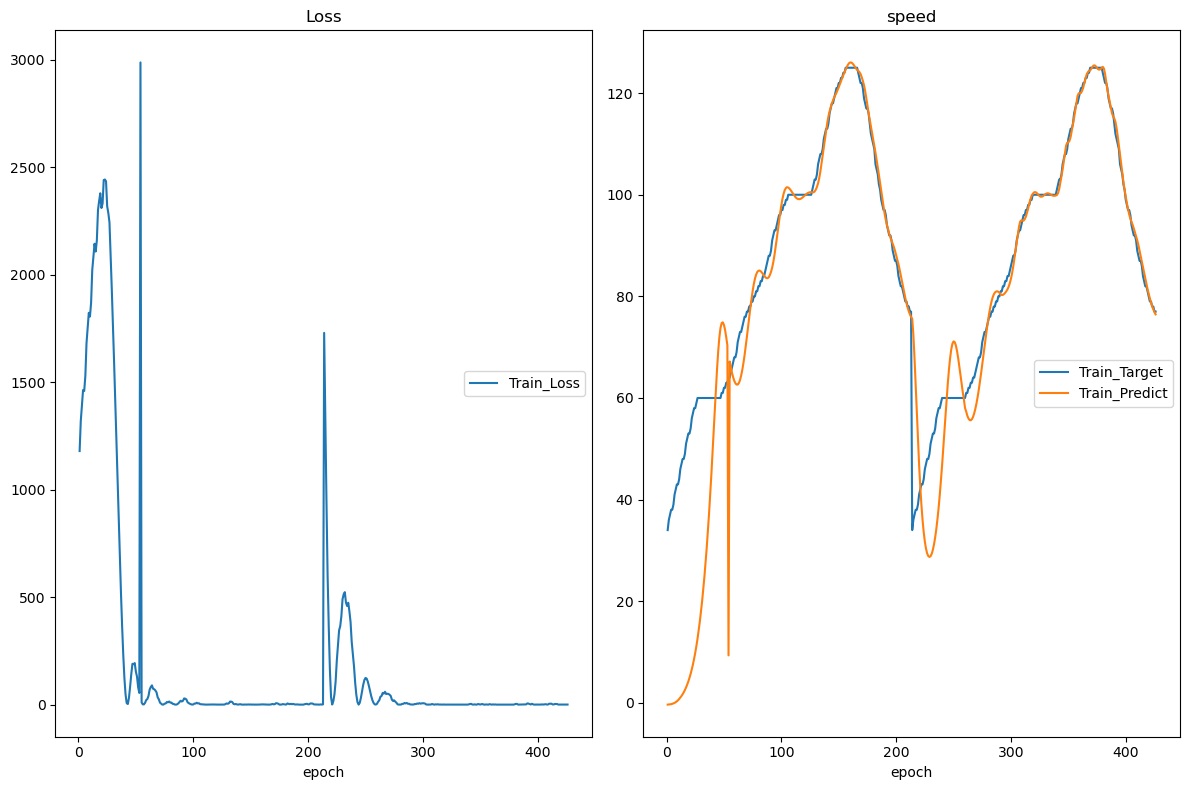

Loss
	Train_Loss       	 (min:    0.000, max: 2988.010, cur:    0.296)
speed
	Train_Target     	 (min:   34.000, max:  125.000, cur:   77.000)
	Train_Predict    	 (min:   -0.349, max:  126.043, cur:   76.456)
Epoch: 1, Average Loss: 62.1176


In [129]:
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on device!")
    device = 'cuda'
else:
    print("No device available!")
# Hyperparameters and model initialization
cnn_output_size = 16  # example size after CNN feature extraction
hidden_size = 32  # LSTM hidden layer size
num_layers = 2  # number of LSTM layers
# Model and optimizer
model = CNNLSTM_V1(cnn_output_size, hidden_size, num_layers, num_features=0)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=0.0001)
criterion = nn.MSELoss()
# Train and eval
train_and_eval(model, 
               dataloaders['tst'][0], 
               dataloaders['tst'][1],
               criterion, optimizer,
               n_epochs=2, 
               model_name='cnn_lstm',
               model_version='v1_1', 
               device=device, 
               checkpoint_dir='./models/task2/',
               live_plot=True,
               save_inv=1)

In [186]:
m = CNNLSTM_V1(cnn_output_size, hidden_size, num_layers, num_features=0)
o = torch.optim.Adam(m.parameters(), lr=0.01, weight_decay=0.0001)
m, o, epoch, log = load_model(m, o, './models/task2/cnn_lstm', 'cnn_lstm_v1_1_1', info=True)
test_loss, targets, predicts = score_matrix(m, dataloaders['tst'][1], criterion, device=device)
print(f"Test Loss: {test_loss}")

models/task2/cnn_lstm/cnn_lstm_v1_1_1.pth
[INFO] Loading model from: models/task2/cnn_lstm/cnn_lstm_v1_1_1.pth at epoch: 1
Test Loss: 88.15576605569748


#### 3.3.2 CNNLSTM_V1_2

In [11]:
storm_names = ['tst']
# additional_features = ['wind_speed', 'relative_time']
datasets = make_datasets(root_dir="./data/Suprise_Storm", 
                 raw_data_dir="./data/raw_data_sup.csv", 
                 storm_names=storm_names, 
                 transform=transformer(image_size=224, repair=True),
                 split_ratio=0.9, 
                 sequence_length=5,
                 additional_features=['wind_speed'],
                 label_type='wind_speed')

dataloaders = make_dataloaders(datasets, storm_names, batch_size=1, shuffle=False)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

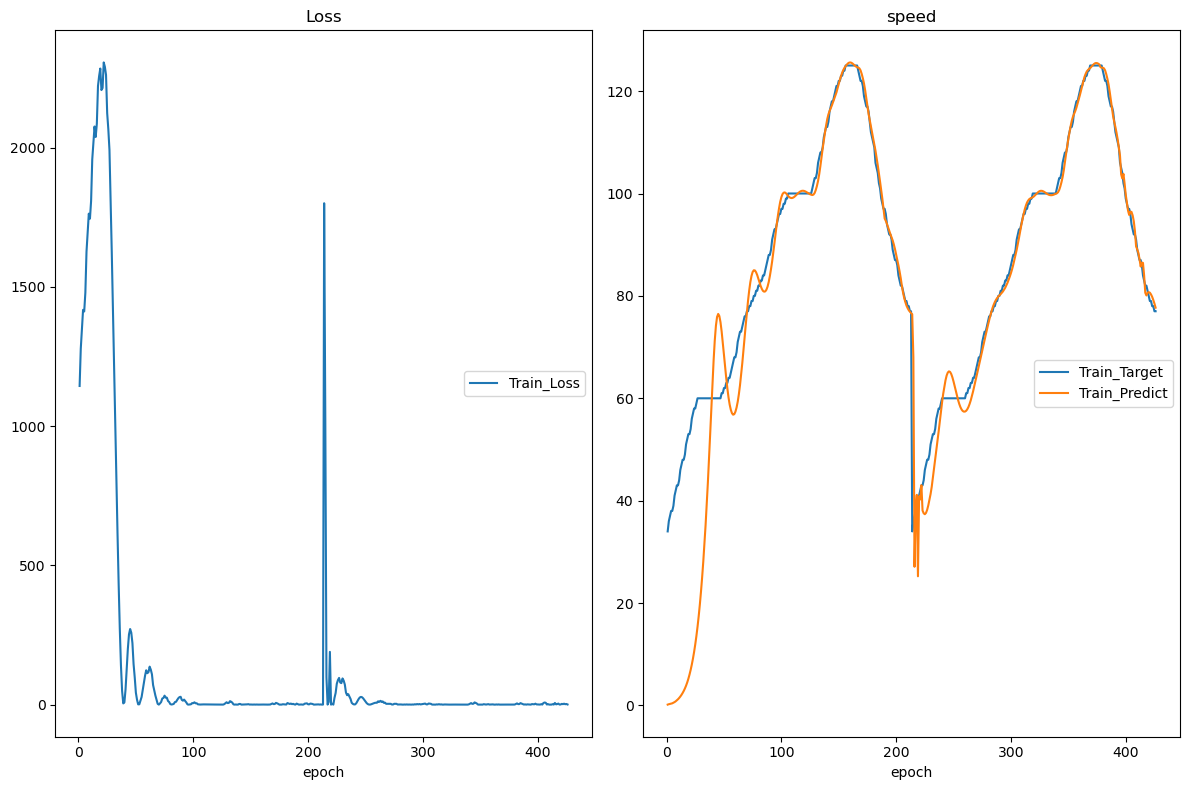

Loss
	Train_Loss       	 (min:    0.000, max: 2306.219, cur:    0.490)
speed
	Train_Target     	 (min:   34.000, max:  125.000, cur:   77.000)
	Train_Predict    	 (min:    0.172, max:  125.598, cur:   77.700)
Epoch: 1, Average Loss: 21.1345


In [134]:
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on device!")
    device = 'cuda'
else:
    print("No device available!")
# Hyperparameters and model initialization
cnn_output_size = 16  # example size after CNN feature extraction
hidden_size = 32  # LSTM hidden layer size
num_layers = 2  # number of LSTM layers
# Model and optimizer
model = CNNLSTM_V1(cnn_output_size, hidden_size, num_layers, num_features=1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=0.0001)
criterion = nn.MSELoss()
# Train and eval
train_and_eval(model, 
               dataloaders['tst'][0], 
               dataloaders['tst'][1],
               criterion, optimizer,
               n_epochs=2, 
               model_name='cnn_lstm',
               model_version='v1_2', 
               device=device, 
               checkpoint_dir='./models/task2/',
               live_plot=True,
               save_inv=1)

In [189]:
m = CNNLSTM_V1(cnn_output_size, hidden_size, num_layers, num_features=1)
o = torch.optim.Adam(m.parameters(), lr=0.01, weight_decay=0.0001)
m, o, epoch, log = load_model(m, o, './models/task2/cnn_lstm', 'cnn_lstm_v1_2_2', info=True)
test_loss, targets, predicts = score_matrix(m, dataloaders['tst'][1], criterion, device=device)
print(f"Test Loss: {test_loss}")

models/task2/cnn_lstm/cnn_lstm_v1_2_2.pth
[INFO] Loading model from: models/task2/cnn_lstm/cnn_lstm_v1_2_2.pth at epoch: 2
Test Loss: 111.1780017671131


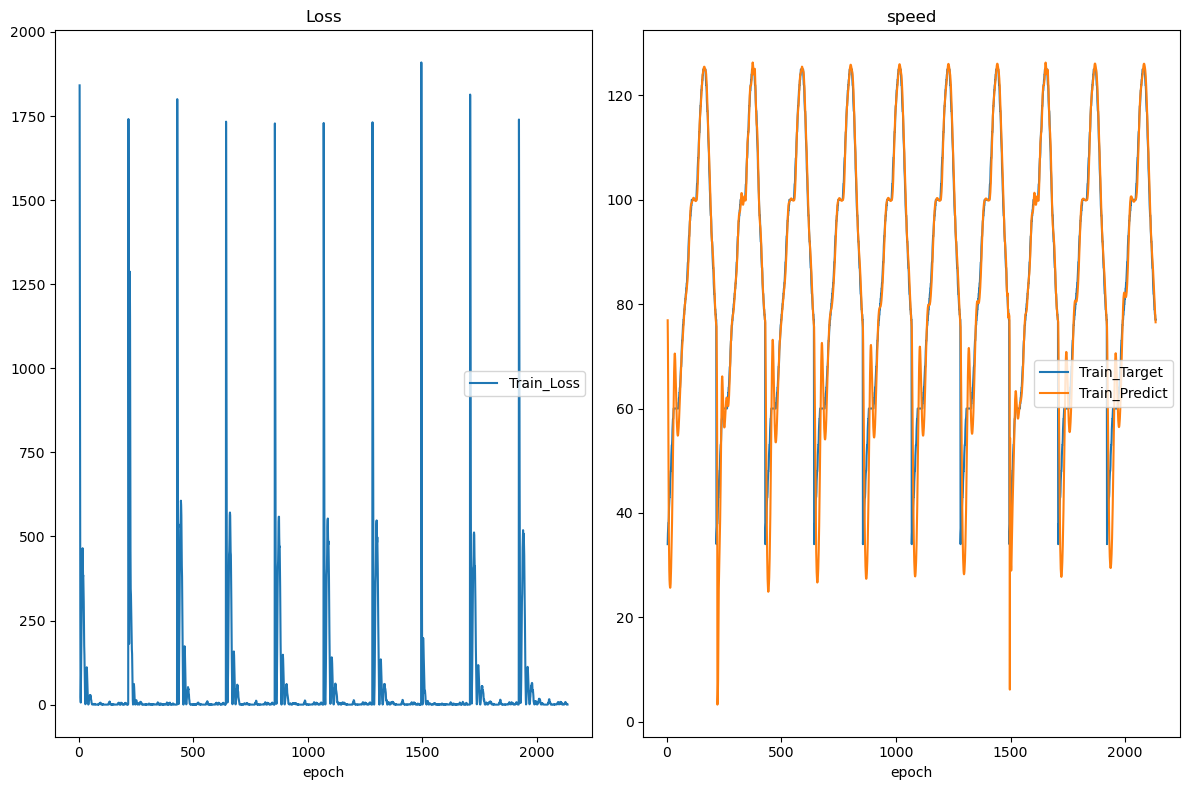

Loss
	Train_Loss       	 (min:    0.000, max: 1909.265, cur:    0.223)
speed
	Train_Target     	 (min:   34.000, max:  125.000, cur:   77.000)
	Train_Predict    	 (min:    3.244, max:  126.333, cur:   76.527)
Epoch: 11, Average Loss: 66.1325


In [190]:
# retrain the model
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on device!")
    device = 'cuda'
else:
    print("No device available!")
# Hyperparameters and model initialization
cnn_output_size = 16  # example size after CNN feature extraction
hidden_size = 32  # LSTM hidden layer size
num_layers = 2  # number of LSTM layers
# Model and optimizer
model = CNNLSTM_V1(cnn_output_size, hidden_size, num_layers, num_features=1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
criterion = nn.MSELoss()
# Train and eval
train_and_eval(model, 
               dataloaders['tst'][0], 
               dataloaders['tst'][1],
               criterion, optimizer,
               n_epochs=10, 
               model_name='cnn_lstm',
               model_version='v1_2', 
               device=device, 
               checkpoint_dir='./models/task2/',
               checkpoint='cnn_lstm_v1_2_2',
               live_plot=True,
               save_inv=1)

In [197]:
m = CNNLSTM_V1(cnn_output_size, hidden_size, num_layers, num_features=1)
o = torch.optim.Adam(m.parameters(), lr=0.01, weight_decay=0.0001)
m, o, epoch, log = load_model(m, o, './models/task2/cnn_lstm', 'cnn_lstm_v1_2_12', info=True)
test_loss, targets, predicts = score_matrix(m, dataloaders['tst'][1], criterion, device=device)
print(f"Test Loss: {test_loss}")

models/task2/cnn_lstm/cnn_lstm_v1_2_12.pth
[INFO] Loading model from: models/task2/cnn_lstm/cnn_lstm_v1_2_12.pth at epoch: 12
Test Loss: 93.36599942616054


#### 3.3.5 CNNLSTM_V2_1

In [199]:
m = CNNLSTM_V2(cnn_output_size=32, hidden_size=64, num_layers=2, num_features=1)

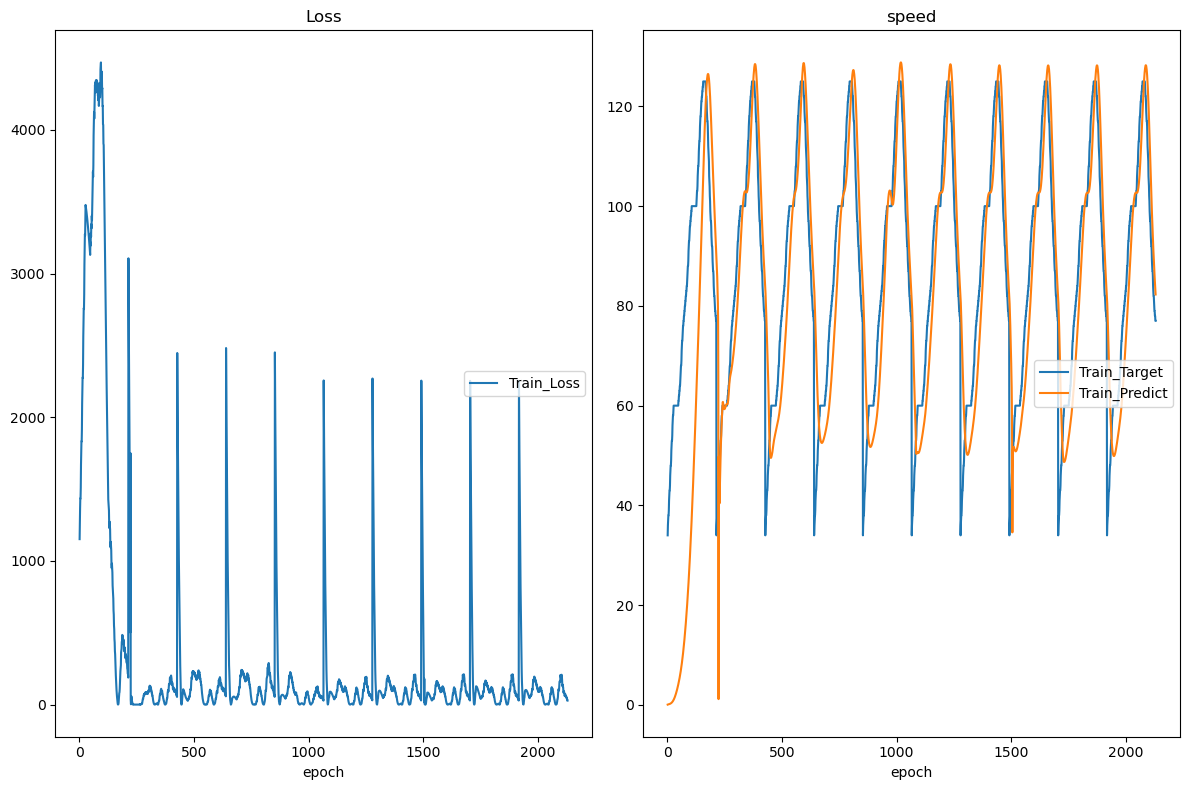

Loss
	Train_Loss       	 (min:    0.000, max: 4469.927, cur:   27.991)
speed
	Train_Target     	 (min:   34.000, max:  125.000, cur:   77.000)
	Train_Predict    	 (min:    0.062, max:  128.808, cur:   82.291)
Epoch: 9, Average Loss: 141.2737


In [200]:
# retrain the model
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on device!")
    device = 'cuda'
else:
    print("No device available!")
# Hyperparameters and model initialization
cnn_output_size = 16  # example size after CNN feature extraction
hidden_size = 32  # LSTM hidden layer size
num_layers = 2  # number of LSTM layers
# Model and optimizer
model = CNNLSTM_V2(cnn_output_size=32, hidden_size=64, num_layers=2, num_features=1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
criterion = nn.MSELoss()
# Train and eval
train_and_eval(model, 
               dataloaders['tst'][0], 
               dataloaders['tst'][1],
               criterion, optimizer,
               n_epochs=10, 
               model_name='cnn_lstm',
               model_version='v2_1', 
               device=device, 
               checkpoint_dir='./models/task2/',
            #    checkpoint='cnn_lstm_v1_2_2',
               live_plot=True,
               save_inv=1)

In [205]:
m = CNNLSTM_V2(cnn_output_size=32, hidden_size=64, num_layers=2, num_features=1)
o = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
m, o, epoch, log = load_model(m, o, './models/task2/cnn_lstm', 'cnn_lstm_v2_1_10', info=True)
test_loss, targets, predicts = score_matrix(m, dataloaders['tst'][1], criterion, device=device)
print(f"Test Loss: {test_loss}")

models/task2/cnn_lstm/cnn_lstm_v2_1_8.pth
[INFO] Loading model from: models/task2/cnn_lstm/cnn_lstm_v2_1_8.pth at epoch: 8
Test Loss: 221.87272407895043


#### 3.3.6 CNNLSTM_V3_1

In [190]:
storm_names = ['tst']
image_size = 256
sequence_length = 3
model_version = 'v3_1'
cnn_output_size =128  # example size after CNN feature extraction
hidden_size = 256  # LSTM hidden layer size
num_layers = 10  # number of LSTM layers
root_dir = "./data/Surpise_Storm_new"
raw_data_dir = "./data/Surprise_Storm_new.csv"

# additional_features = ['wind_speed', 'relative_time']
datasets = make_datasets(root_dir=root_dir, 
                 raw_data_dir=raw_data_dir, 
                 storm_names=storm_names, 
                 transform=transformer(image_size=image_size, repair=True),
                 split_ratio=1, 
                 sequence_length=sequence_length,
                 additional_features=['relative_time'],
                 label_type='wind_speed')

dataloaders = make_dataloaders(datasets, storm_names, batch_size=16, shuffle=False)
x = next(iter(dataloaders['tst'][0]))

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [61]:
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on device!")
    device = 'cuda'
else:
    print("No device available!")
# Hyperparameters and model initialization
# Model and optimizer
model = CNNLSTM_V3(cnn_output_size, hidden_size, num_layers, num_features=1, image_size=image_size)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.MSELoss()
# Train and eval
train_and_eval(model, 
               dataloaders['tst'][0], 
               dataloaders['tst'][1],
               criterion, optimizer,
               n_epochs=100, 
               model_name='cnn_lstm',
               model_version=model_version, 
               device=device, 
               checkpoint_dir='./models/task2/',
               live_plot=False,
               save_inv=10)

Cuda installed! Running on device!


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 0, Average Loss: 2047.5369, Total Loss: 32760.5906
Epoch: 1, Average Loss: 1361.5733, Total Loss: 21785.1733
Epoch: 2, Average Loss: 239.2452, Total Loss: 3827.9229
Epoch: 3, Average Loss: 260.9687, Total Loss: 4175.4996
Epoch: 4, Average Loss: 120.5064, Total Loss: 1928.1027
Epoch: 5, Average Loss: 82.8816, Total Loss: 1326.1050
Epoch: 6, Average Loss: 54.0721, Total Loss: 865.1535
Epoch: 7, Average Loss: 34.4327, Total Loss: 550.9225
Epoch: 8, Average Loss: 24.1586, Total Loss: 386.5378
Epoch: 9, Average Loss: 18.8771, Total Loss: 302.0337
Epoch: 10, Average Loss: 13.8859, Total Loss: 222.1742
Epoch: 11, Average Loss: 10.7763, Total Loss: 172.4212
Epoch: 12, Average Loss: 9.5058, Total Loss: 152.0935
Epoch: 13, Average Loss: 14.9093, Total Loss: 238.5495
Epoch: 14, Average Loss: 33.7671, Total Loss: 540.2730
Epoch: 15, Average Loss: 28.7444, Total Loss: 459.9105
Epoch: 16, Average Loss: 195.9405, Total Loss: 3135.0486
Epoch: 17, Average Loss: 286.4312, Total Loss: 4582.8993
Ep

In [188]:
# retrain the model

# if torch.cuda.device_count() > 0 and torch.cuda.is_available():
#     print("Cuda installed! Running on device!")
#     device = 'cuda'
# else:
#     print("No device available!")
# # Hyperparameters and model initialization
# # Model and optimizer
# model = CNNLSTM_V3(cnn_output_size, hidden_size, num_layers, num_features=1, image_size=image_size)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)
# criterion = nn.MSELoss()
# # Train and eval
# train_and_eval(model, 
#                dataloaders['tst'][0], 
#                dataloaders['tst'][1],
#                criterion, optimizer,
#                n_epochs=100, 
#                model_name='cnn_lstm',
#                model_version=model_version, 
#                device=device, 
#                checkpoint_dir='./models/task2/',
#                checkpoint='cnn_lstm_v3_1_160',
#                live_plot=False,
#                save_inv=1)

Cuda installed! Running on device!
models/task2/cnn_lstm/cnn_lstm_v3_1_160.pth
[INFO] Loading model from: models/task2/cnn_lstm/cnn_lstm_v3_1_160.pth at epoch: 160


 62%|######1   | 160/260 [00:00<?, ?it/s]

Epoch: 160, Average Loss: 34.2800, Total Loss: 34.2800
Epoch: 161, Average Loss: 22.2724, Total Loss: 22.2724
Epoch: 162, Average Loss: 12.0865, Total Loss: 12.0865
Epoch: 163, Average Loss: 5.2316, Total Loss: 5.2316
Epoch: 164, Average Loss: 2.1776, Total Loss: 2.1776
Epoch: 165, Average Loss: 2.4474, Total Loss: 2.4474
Epoch: 166, Average Loss: 4.9714, Total Loss: 4.9714
Epoch: 167, Average Loss: 8.4799, Total Loss: 8.4799
Epoch: 168, Average Loss: 11.7852, Total Loss: 11.7852
Epoch: 169, Average Loss: 14.0452, Total Loss: 14.0452
Epoch: 170, Average Loss: 14.8110, Total Loss: 14.8110
Epoch: 171, Average Loss: 14.0458, Total Loss: 14.0458
Epoch: 172, Average Loss: 12.0465, Total Loss: 12.0465
Epoch: 173, Average Loss: 9.3484, Total Loss: 9.3484
Epoch: 174, Average Loss: 6.5059, Total Loss: 6.5059
Epoch: 175, Average Loss: 3.9983, Total Loss: 3.9983
Epoch: 176, Average Loss: 2.1686, Total Loss: 2.1686
Epoch: 177, Average Loss: 1.1691, Total Loss: 1.1691
Epoch: 178, Average Loss: 0.96

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

164.05270282946907


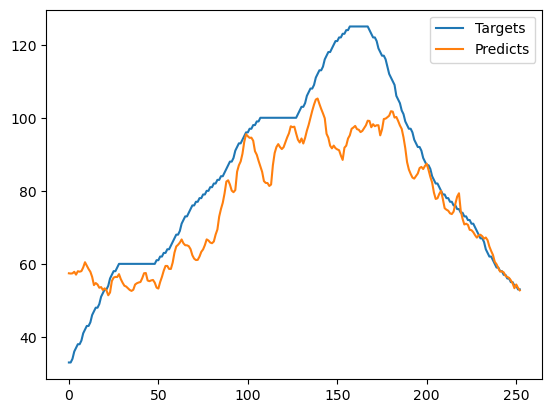

In [191]:
datasets = make_datasets(root_dir=root_dir, 
                 raw_data_dir=raw_data_dir, 
                 storm_names=storm_names, 
                 transform=transformer(image_size=image_size, repair=True),
                 split_ratio=1, 
                 sequence_length=sequence_length,
                 additional_features=['relative_time'],
                 label_type='wind_speed')

dataloaders = make_dataloaders(datasets, storm_names, batch_size=1, shuffle=False)
x = next(iter(dataloaders['tst'][0]))

test_loss, targets, predicts = score_matrix(model, dataloaders['tst'][0], criterion, device=device)
print(test_loss)
plt.plot(targets, label='Targets')
plt.plot(predicts, label='Predicts')
plt.legend()

models/task2/cnn_lstm/cnn_lstm_v3_1_265.pth
[INFO] Loading model from: models/task2/cnn_lstm/cnn_lstm_v3_1_265.pth at epoch: 265
150.26888860581008


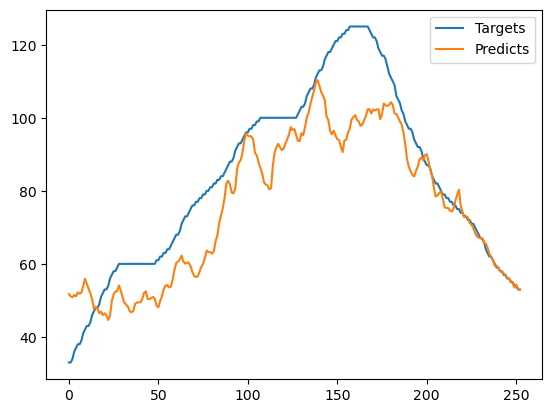

In [249]:
m = CNNLSTM_V3(cnn_output_size, hidden_size, num_layers, num_features=1, image_size=image_size)
o = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
m, o, epoch, log = load_model(m, o, './models/task2/cnn_lstm', 'cnn_lstm_v3_1_265', info=True)
test_loss, targets, predicts = score_matrix(m, dataloaders['tst'][0], criterion, device=device)
print(test_loss)
plt.plot(targets, label='Targets')
plt.plot(predicts, label='Predicts')
plt.legend()

## 5. Final Model

In [17]:
def extract_id_from_filename(filename):
    # Assuming the ID is the part between the last underscore and the dot
    if filename[-3:] == "jpg":
        match = re.search(r'_(\d+)\.', filename)
    else:
        match = re.search(r'_(\d+)_', filename)
    return int(match.group(1)) if match else None

def read_images_recursive(folder_path):
    image_data = []
    for root, dirs, files in os.walk(folder_path):
        folder_name = os.path.basename(root)
        for file in files:
            if file.endswith((".jpg", ".jpeg")):
                image_path = os.path.join(root, file)
                image_id = extract_id_from_filename(file)
                data = {
                    "Id": image_id,
                    "Storm_Name": folder_name,
                    "Image_Path": image_path
                }
                image_data.append(data)
    return image_data

def read_feature_jsons_recursive(folder_path):
    feature_data_list = []
    for root, dirs, files in os.walk(folder_path):
        folder_name = os.path.basename(root)
        for file in files:
            if file.endswith("_features.json"):
                image_id = extract_id_from_filename(file)
                with open(os.path.join(root, file), "r") as json_file:
                    json_data = json.load(json_file)
                    data = {
                        "Id": image_id,
                        "Storm_Name": folder_name,
                        "Relative_time": int(json_data["relative_time"]),
                        "Ocean": int(json_data["ocean"]),
                    }
                    feature_data_list.append(data)
    return feature_data_list

def read_label_jsons_recursive(folder_path):
    label_data_list = []
    for root, dirs, files in os.walk(folder_path):
        folder_name = os.path.basename(root)
        for file in files:
            if file.endswith("_label.json"):
                image_id = extract_id_from_filename(file)
                with open(os.path.join(root, file), "r") as json_file:
                    json_data = json.load(json_file)
                    data = {
                        "Id": image_id,
                        "Storm_Name": folder_name,
                        "Wind_Speed": json_data["wind_speed"],
                    }
                    label_data_list.append(data)
    return label_data_list

In [22]:
data = helper.get_raw_data("../../data/Surprise_Storm_Predicted")
data.to_csv("../../data/Surprise_Storm_Predicted.csv", index=False)

In [23]:
data[-13:] # generate a dummy dataset to show the final result of the best model

,Storm_Name,Id,Wind_Speed,Relative_time,Ocean,Image_Path
242,tst,6,37,12599,1,../../data/Surprise_Storm_Predicted/tst/tst_00...
243,tst,186,105,401400,1,../../data/Surprise_Storm_Predicted/tst/tst_18...
244,tst,174,121,374401,1,../../data/Surprise_Storm_Predicted/tst/tst_17...
245,tst,240,60,518400,1,../../data/Surprise_Storm_Predicted/tst/tst_24...
246,tst,91,87,196199,1,../../data/Surprise_Storm_Predicted/tst/tst_09...
247,tst,15,46,32399,1,../../data/Surprise_Storm_Predicted/tst/tst_01...
248,tst,59,65,126000,1,../../data/Surprise_Storm_Predicted/tst/tst_05...
249,tst,60,66,129599,1,../../data/Surprise_Storm_Predicted/tst/tst_06...
250,tst,236,63,509400,1,../../data/Surprise_Storm_Predicted/tst/tst_23...
251,tst,26,57,55801,1,../../data/Surprise_Storm_Predicted/tst/tst_02...


In [24]:
storm_names = ['tst']
image_size = 256
sequence_length = 3
model_version = 'v3_1'
cnn_output_size =128  # example size after CNN feature extraction
hidden_size = 256  # LSTM hidden layer size
num_layers = 10  # number of LSTM layers
root_dir = "../../data/Surprise_Storm_Predicted"
raw_data_dir = "../../data/Surprise_Storm_Predicted.csv"

datasets = make_datasets(root_dir=root_dir, 
                 raw_data_dir=raw_data_dir, 
                 storm_names=storm_names, 
                 transform=transformer(image_size=image_size, repair=True),
                 split_ratio=1, 
                 sequence_length=sequence_length,
                 additional_features=['relative_time'],
                 label_type='wind_speed')

dataloaders = make_dataloaders(datasets, storm_names, batch_size=1, shuffle=False)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [34]:
features_json = read_feature_jsons_recursive("../../data/Surprise_Storm_Predicted")
df_features = pd.DataFrame(features_json)

In [35]:
# sort the dataframe by Relative_time
df_features = df_features.sort_values(by=['Relative_time'])
Relative_time = df_features['Relative_time']
# Relative_time  to list
Relative_time = Relative_time.tolist()

In [39]:
Relative_time = Relative_time[-13:]

In [27]:
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on device!")
    device = 'cuda'
else:
    print("No device available!")

Cuda installed! Running on device!


In [40]:
criterion = nn.MSELoss()
m = CNNLSTM_V3(cnn_output_size, hidden_size, num_layers, num_features=1, image_size=image_size)
o = torch.optim.Adam(m.parameters(), lr=0.001, weight_decay=0.0001)
m, o, epoch, log = load_model(m, o, './models', 'cnn_lstm_v3_1_265', info=True)
test_loss, targets, predicts = score_matrix(m, dataloaders['tst'][0], criterion, device=device)
results = predicts[-13:]
predicts = pd.DataFrame([Relative_time, results]).T
predicts.columns = ['Relative_time', 'Wind_Speed']
predicts.to_csv("../../data/results/nicholas_windpredictions.csv", index=False, header=False)

models/cnn_lstm_v3_1_265.pth
[INFO] Loading model from: models/cnn_lstm_v3_1_265.pth at epoch: 265


In [41]:
predicts

,Relative_time,Wind_Speed
0,522000.0,58.893951
1,523800.0,57.903469
2,525601.0,57.914341
3,529199.0,57.433643
4,530999.0,56.595448
5,532799.0,56.272369
6,534599.0,55.930000
7,536398.0,55.351665
8,539999.0,54.783096
9,541799.0,53.490471
